# Lymph node data - B cell activation

The aim of this analysis is to find traces of B cell activation in human Lymph node scRNA-Seq data.

CAVE: It is unclear to me how common this process is. Does it only happen during infection? Does it happen all the time? Would we expect to see it in these data?

### 1. Load data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

I loaded the GSE131907_Lung_Cancer_raw_UMI_matrix.rds file provided on GEO intor R. For this I had to generate a new R project and changed the r environment R_MAX_VSIZE to 100GB. The rds-file contained a data.frame with the barcode_sample-annotated cells. I selected the cells taken from healthy lymph nodes and exported the table as csv. Now, I can load the csv into python and transform it into a andata object!

In [2]:
scLN = sc.read_csv("../02_data/02_processed_data/GSE131907_nLN_raw_UMI_matrix.csv")

In [3]:
# vars are supposed to be the genes, obs the cells
scLN = scLN.transpose()

Annotate scRNA-seq data.

In [5]:
annotation = pd.read_csv("../02_data/02_processed_data/GSE131907_Lung_Cancer_cell_annotation.txt", sep="\t")
annotation.index = annotation["Index"]

In [6]:
bool_ls = np.in1d(annotation["Index"], scLN.obs.index.values)

In [7]:
annotation = annotation.loc[bool_ls,]

In [8]:
scLN.obs["sample"] = annotation["Sample"]
scLN.obs["Sample_Origin"] = annotation["Sample_Origin"]
scLN.obs["Cell_type.refined"] = annotation["Cell_type.refined"]
scLN.obs["Cell_subtype"] = annotation["Cell_subtype"]

In [9]:
scLN.var_names_make_unique()  

### 2. Quality Control and Normalization

In [10]:
scLN.var["mt"] = scLN.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(scLN, qc_vars=["mt"], inplace=True)

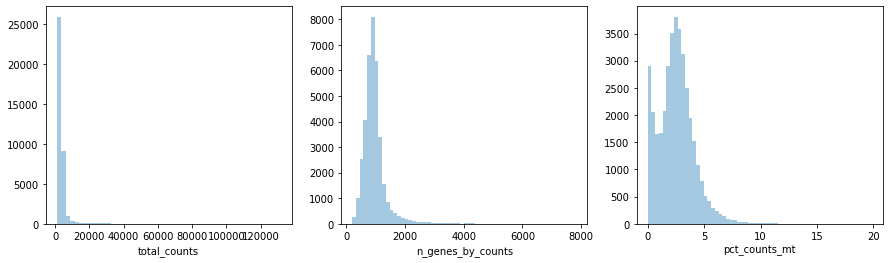

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.distplot(scLN.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(scLN.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
sns.distplot(scLN.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[2])

... storing 'sample' as categorical
... storing 'Sample_Origin' as categorical
... storing 'Cell_type.refined' as categorical
... storing 'Cell_subtype' as categorical


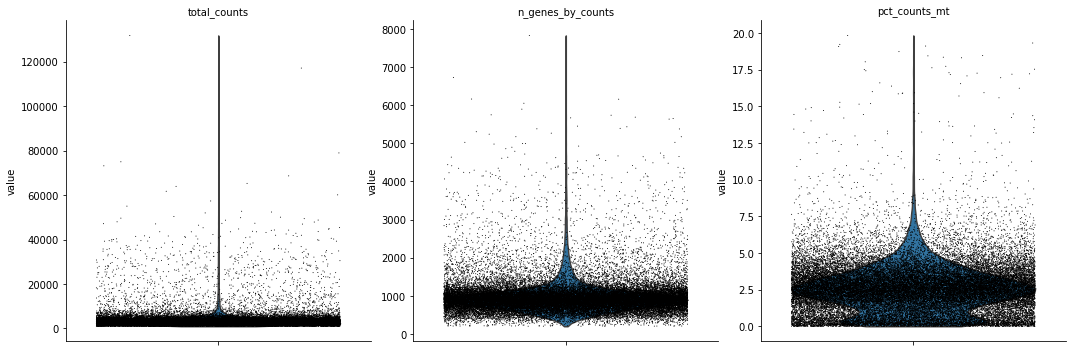

In [12]:
sc.pl.violin(scLN, ['total_counts','n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

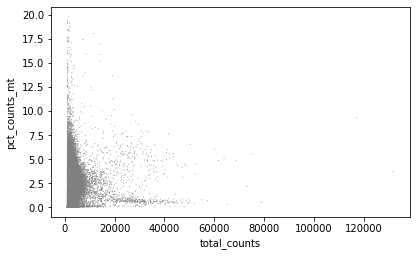

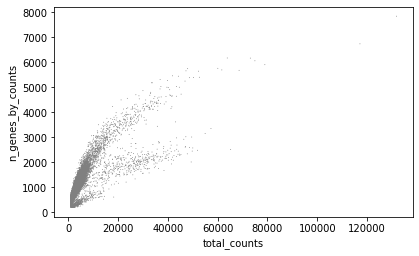

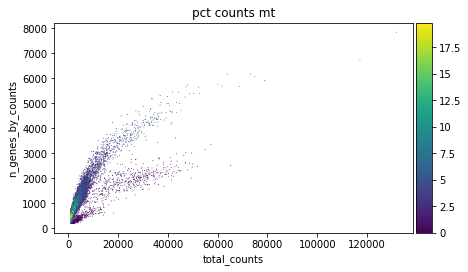

In [13]:
sc.pl.scatter(scLN, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [14]:
# remove outliers
scLN = scLN[scLN.obs.total_counts < 18000, :]
scLN = scLN[scLN.obs.n_genes_by_counts < 2000, :]
scLN = scLN[scLN.obs.pct_counts_mt < 7, :]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


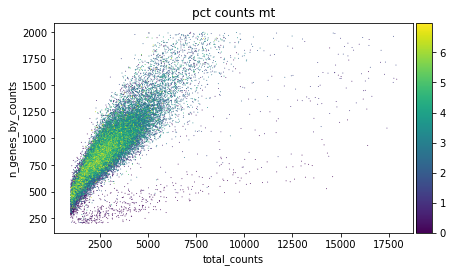

In [15]:
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [16]:
# Normalize counts to 10,000 reads per cell
sc.pp.normalize_total(scLN, target_sum=1e4)

/Users/albero/scanpy/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
# Logarithmize the data
sc.pp.log1p(scLN)

In [18]:
# Identify highly variable genes
sc.pp.highly_variable_genes(scLN)

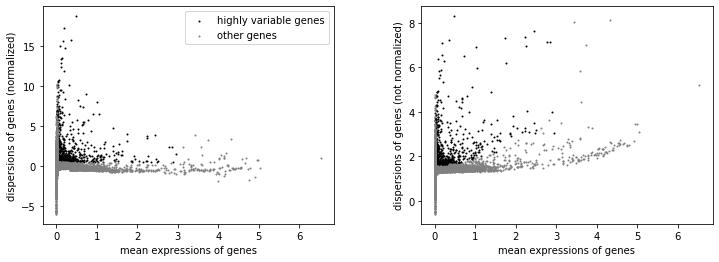

In [19]:
# equivalent to the DESeq2 MA-plot
sc.pl.highly_variable_genes(scLN)

In [20]:
scLN.raw = scLN

In [21]:
# proceed only with the highly variable genes
scLN = scLN[:, scLN.var.highly_variable]
# now we proceed with only 916 instead of 29634 genes

In [22]:
# scale data to unit variance
sc.pp.scale(scLN, max_value=10)

/Users/albero/scanpy/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 3. Visualize data

In [25]:
sc.tl.pca(scLN, svd_solver='arpack')

In [26]:
# compute the neighbors
sc.pp.neighbors(scLN)

In [28]:
# compute UMAP
sc.tl.umap(scLN)

In [ ]:
# sc.tl.tsne(scLN)

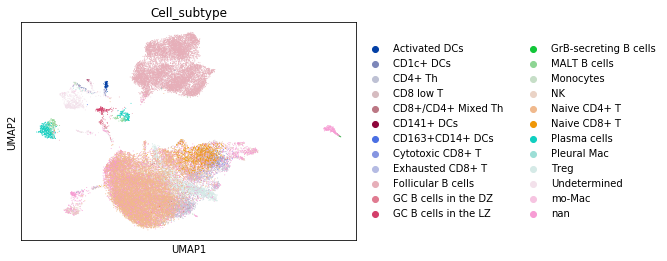

In [29]:
sc.pl.umap(scLN, color=["Cell_subtype"], wspace=0.4)

In [30]:
# sc.pl.tsne(scLN, color=["Cell_subtype"], wspace=0.4)

### 4. Trajectory of B cells in LN

In [31]:
# select only B cells
scLN_bc = scLN[scLN.obs["Cell_type.refined"] == "B lymphocytes"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


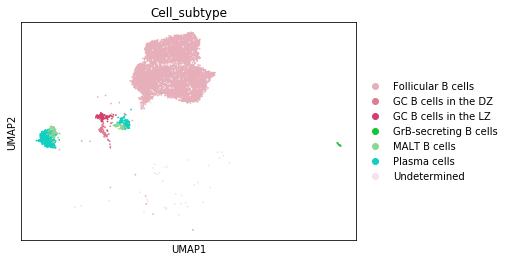

In [32]:
sc.pl.umap(scLN_bc, color=["Cell_subtype"], wspace=0.4)

In [33]:
# Rerun PCA now only on the B cell samples

sc.tl.pca(scLN_bc, svd_solver='arpack')

In [35]:
sc.tl.diffmap(scLN_bc)

/Users/albero/scanpy/scanpy/neighbors/__init__.py:856: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0/q, 0, W.shape[0], W.shape[0])
/Users/albero/scanpy/scanpy/neighbors/__init__.py:866: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0/z, 0, K.shape[0], K.shape[0])


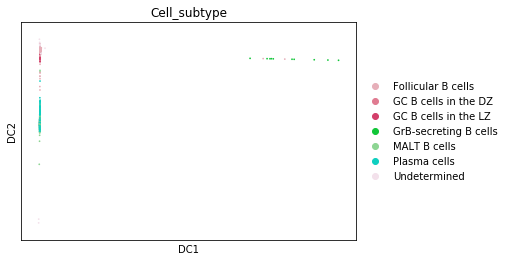

In [48]:
sc.pl.diffmap(scLN_bc, color=['Cell_subtype'], components='1,2')

It seems as if the GrB-secreting B cells are fairly distinct from the other subsets, which is very much in line with the UMAP results.

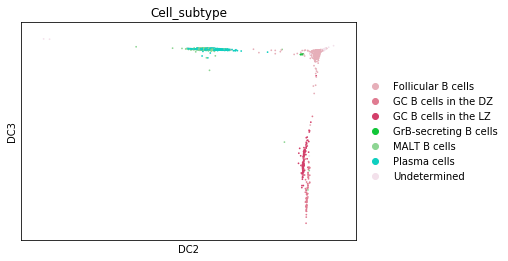

In [54]:
sc.pl.diffmap(scLN_bc, color=['Cell_subtype'], components='2,3')

Let's try and remove the GrB-secreting B cells and the undetermined cells. We risk loosing some biologically relevant information, but it might also make the analysis more interpretable.

In [63]:
scLN_bc_subset = scLN_bc[scLN_bc.obs["Cell_subtype"] != "GrB-secreting B cells"]
scLN_bc_subset = scLN_bc_subset[scLN_bc_subset.obs["Cell_subtype"] != "Undetermined"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


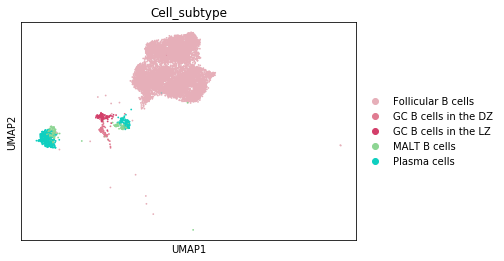

In [64]:
sc.pl.umap(scLN_bc_subset, color=["Cell_subtype"], wspace=0.4)

In [65]:
sc.tl.pca(scLN_bc_subset, svd_solver='arpack')
sc.tl.diffmap(scLN_bc_subset)

/Users/albero/scanpy/scanpy/neighbors/__init__.py:856: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0/q, 0, W.shape[0], W.shape[0])
/Users/albero/scanpy/scanpy/neighbors/__init__.py:866: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0/z, 0, K.shape[0], K.shape[0])


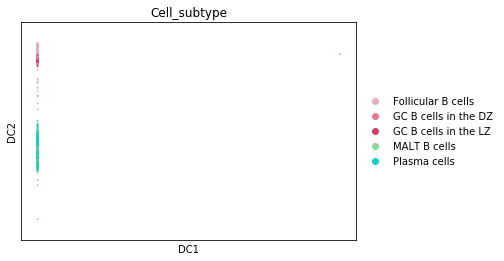

In [66]:
sc.pl.diffmap(scLN_bc_subset, color=['Cell_subtype'], components='1,2')

Still, there is an outlier that explains the DC1. Let's look at DC2 vs DC3 instead.

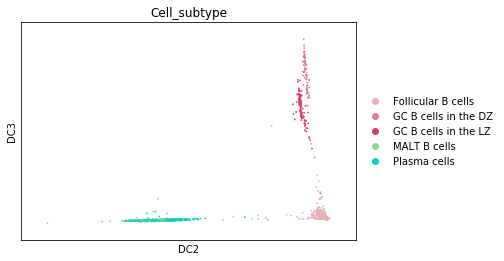

In [67]:
sc.pl.diffmap(scLN_bc_subset, color=['Cell_subtype'], components='2,3')

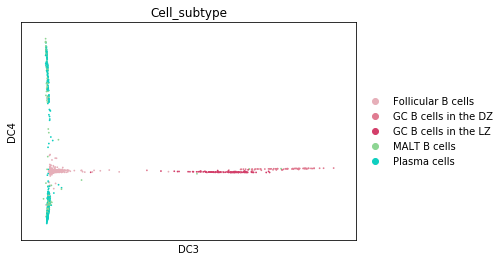

In [83]:
sc.pl.diffmap(scLN_bc_subset, color=['Cell_subtype'], components='3,4')

### 5. Ligrec predicted interactions of B cells

In [74]:
# compute all interactions for all samples
res_scLN = sq.gr.ligrec(scLN, "Cell_subtype",
                   fdr_method=None, copy=True,
                   interactions_params={"resources": "CellPhoneDB"},
                   threshold=0.1, seed=0, n_jobs=1) #  n_perms=10000 removed --> default is 10000
df_res_scLN = res_scLN.pvalues

/opt/anaconda3/lib/python3.7/site-packages/omnipath/_core/requests/_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func


  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [75]:
print("Number of CellPhoneDB interactions:", len(df_res_scLN))

df_res_scLN.head()

Number of CellPhoneDB interactions: 444


cluster_1     Activated DCs                                               \
cluster_2     Activated DCs CD141+ DCs CD163+CD14+ DCs CD1c+ DCs CD4+ Th   
source target                                                              
JAG2   NOTCH1           NaN        NaN             NaN       NaN     NaN   
DLL1   NOTCH1           NaN        NaN             NaN       NaN     NaN   
JAG1   NOTCH1           NaN        NaN             NaN       NaN     NaN   
TNF    NOTCH1           NaN        NaN             NaN       NaN     NaN   
DLL4   NOTCH1           NaN        NaN             NaN       NaN     NaN   

cluster_1                                                                     \
cluster_2     CD8 low T CD8+/CD4+ Mixed Th Cytotoxic CD8+ T Exhausted CD8+ T   
source target                                                                  
JAG2   NOTCH1       NaN                NaN              NaN              NaN   
DLL1   NOTCH1       NaN                NaN              NaN              NaN   
JAG1   NOTCH1       NaN                NaN              NaN              NaN   
TNF    NOTCH1       NaN                NaN              NaN              NaN   
DLL4   NOTCH1       NaN                NaN              NaN              NaN   

cluster_1                         ...       nan                                \
cluster_2     Follicular B cells  ... Monocytes  NK Naive CD4+ T Naive CD8+ T   
source target                     ...                                           
JAG2   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
DLL1   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
JAG1   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
TNF    NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
DLL4   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   

cluster_1                                                            
cluster_2     Plasma cells Pleural Mac Treg Undetermined mo-Mac nan  
source target                                                        
JAG2   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
DLL1   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
JAG1   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
TNF    NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
DLL4   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  

[5 rows x 576 columns]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


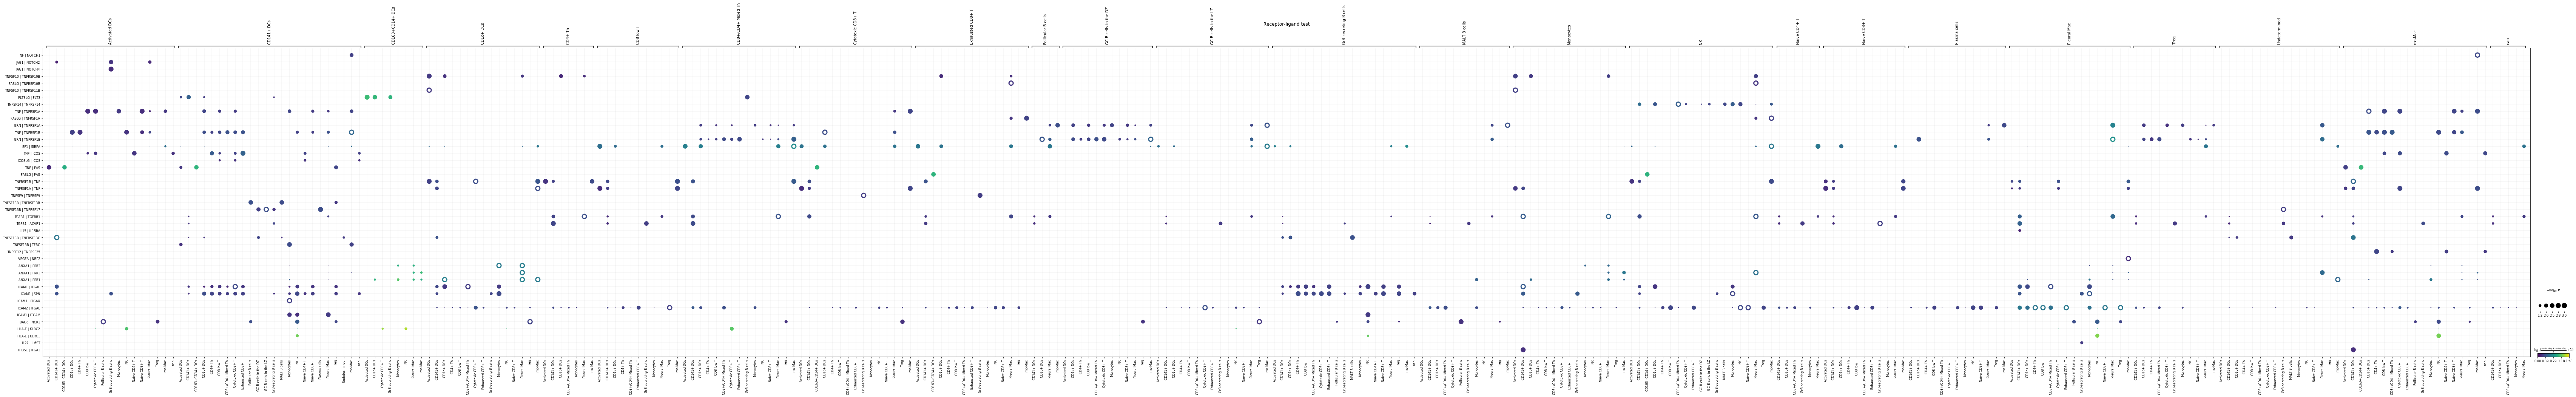

In [76]:
sq.pl.ligrec(res_scLN)

As the follicular B cells seem to be the source of the trajectory, let's describe their Interactions!

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


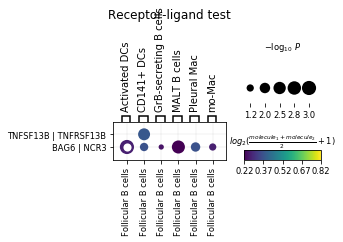

In [77]:
# Input signals
sq.pl.ligrec(res_scLN, target_groups = "Follicular B cells")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


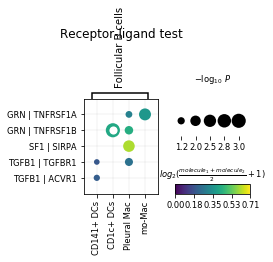

In [78]:
# Output signals
sq.pl.ligrec(res_scLN, source_groups = "Follicular B cells")

If the cluster of pleural Macrophages is correctly annotated, this interaction is most likely not biologically relevant, as those cells are not within the lymph node.